# Plot the entry and exit points

#### Script same as ShowTrajectory - modified to plot the exit and entry points on the clutter

In [ ]:
import glob
import os
import pandas as pd

import numpy as np
from tqdm.notebook import tqdm

# matplot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch
from mpl_toolkits.mplot3d import Axes3D 
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.ticker as ticker


# To get some interaction
from ipywidgets import interactive, interact, widgets
# Config
import configparser
# Our tools
from tools.loading import load_conditions_table
from tools.plot_trajectory import plot_trajectory
import mcampy.core.transforms as tf
from navipy.tools.plots import get_color_dataframe
from navipy.trajectories import Trajectory
from mpl_toolkits.mplot3d.art3d import Line3DCollection


# %matplotlib notebook
import math

%load_ext autoreload
%autoreload 2
#%matplotlib qt

In [628]:
# We read the config
config = configparser.ConfigParser()
config.read(['defaultconfig.ini', 'config.ini']);
rootfoldercalib = config['Path']['path2calibrations']
rootfolderdata = config['Path']['path2recordings']
conditions_fname = config['Path']['path2conditions']
path2traj = config['Path']['path2trajectories']
obj_file = config['Path']['template2objects']

In [629]:
bee_id = '33R'
recording = '20210414_134257'

In [630]:
# get the recording
path2traj = os.path.join(path2traj,('{}/'.format(recording)))
trajectories_file = glob.glob(os.path.join(path2traj, '*[0-9].csv'))
trajectories_file = pd.Series({os.path.basename(os.path.splitext(f)[0]):f for f in trajectories_file})


In [ ]:
# get trajectory csv file ---- traj_nv

common_path = '/path/'

recording_path = os.path.join(common_path,bee_id,recording_condition)
traj_nv = pd.read_csv('{0}/traj_nv_{1}.csv'.format(recording_path,recording_condition))

In [632]:
exit_mid_mean = pd.read_csv('{0}/exitmid_mean_df_{1}.csv'.format(recording_path,recording_condition),
                       header=[0]) # in_mid_out direction data
exit_mid_mean.head()

,Unnamed: 0,x_mean,y_mean,z_mean,time_mean
0,0,-0.183228,-0.248698,0.290136,5.648
1,1,-0.128695,0.222592,0.264101,7.776
2,2,-0.399311,0.016894,0.223120,37.264
3,3,-0.291917,-0.219970,0.001300,62.976


In [633]:
entry_mid_mean = pd.read_csv('{0}/entrymid_mean_df_{1}.csv'.format(recording_path,recording_condition),
                       header=[0]) # out_mid_in direction data
entry_mid_mean.head()

,Unnamed: 0,x_mean,y_mean,z_mean,time_mean
0,0,-0.048503,-0.261503,0.265123,4.264
1,1,-0.219321,-0.002002,0.282017,6.816
2,2,-0.195302,0.037224,0.289166,8.552
3,3,0.157068,-0.332056,0.276753,43.184
4,4,-0.378277,-0.003257,-0.008251,64.024


In [635]:
trajectories_file[0] # if chnaged stuff is used, then there will be 0 in [] all the time 

'/media/vedant/Docs/MSc_Bhehaviour/Master_Project/git_clone_stuff/flightaltitude/exp_20210413/data/Trajectories/20210414_134257/20210414_134257_20210414_105619.csv'

In [636]:
traj_nv.head()

,Unnamed: 0,frame_i,x,y,z,w,bee_distance,timeseries
0,0,6094,-0.664576,-0.279497,0.178553,6.139034e-16,0.720957,0.000
1,1,6095,-0.650318,-0.278107,0.174295,6.105464e-16,0.707288,0.016
2,2,6096,-0.641425,-0.278444,0.169414,6.101048e-16,0.699254,0.032
3,3,6097,-0.627342,-0.276429,0.164956,6.059082e-16,0.685545,0.048
4,4,6098,-0.615919,-0.275951,0.161344,6.040896e-16,0.674911,0.064


In [637]:
traj_clutter = traj_nv[['frame_i','x','y','z','w']]

In [638]:
traj_clutter.dropna().head()

,frame_i,x,y,z,w
0,6094,-0.664576,-0.279497,0.178553,6.139034e-16
1,6095,-0.650318,-0.278107,0.174295,6.105464e-16
2,6096,-0.641425,-0.278444,0.169414,6.101048e-16
3,6097,-0.627342,-0.276429,0.164956,6.059082e-16
4,6098,-0.615919,-0.275951,0.161344,6.040896e-16


In [639]:
fps = 62.5

In [640]:
# original original
n=5
nminute = n*(fps*60)
first_frame = traj_clutter.dropna().index[0]
selected_traj = traj_clutter[:]


In [641]:
# loading object positions
#object_pos = pd.read_hdf(obj_file,'/object_pos/relative')
objectfile = config['Path']['template2objects']
object_pos = pd.read_hdf(obj_file,'/object_pos/relative')

#object_pos = pd.read_csv(objectfile, index_col = [0])
object_pos['z'] = 0 # Because on the floor
object_pos/=1000 # Because calibration was done in m (mm->m)

In [642]:
center = pd.read_hdf(obj_file,'/object_pos/center')/1000

In [643]:
is3d = True

In [644]:
nest_loc = object_pos.loc['nest']
nest_loc.x

0.03

In [645]:
# Function to get the distance (hypoteneous between two points)
def get_hypo(variable_loc,fixed_loc): 
    """ Function to get the hypoteneous. It will be used to get the distance between the center and bee location.""" 
    """ Otherwise to get the distance between the nest and bee location"""
    # varial_locParam - location variable in the loop
    # focal_loc - fixed location like nest or center
    x_coord = variable_loc.x
    y_coord = variable_loc.y
    distance = list ()
    
    for ii in range(len(x_coord)):
        dist = math.hypot(fixed_loc[0]-x_coord.iloc[ii],fixed_loc[1]-y_coord.iloc[ii])
        distance.append(dist)
    
    return distance

In [646]:
objects_only = object_pos.drop('nest') # Nest is not an object

In [647]:
clutter_center = [0,0] #center of the clutter
# dsitance between the object and the center of the clutter
centerObject_dist = get_hypo(objects_only,clutter_center) 

In [648]:
# slecect the largest distance 
clutter_center = [0,0] #center of the clutter
clut_radius = max(centerObject_dist)
clut_height = 0.282 
# just to check
print(clut_radius)
clut_height = 0.282

0.3878479083352133


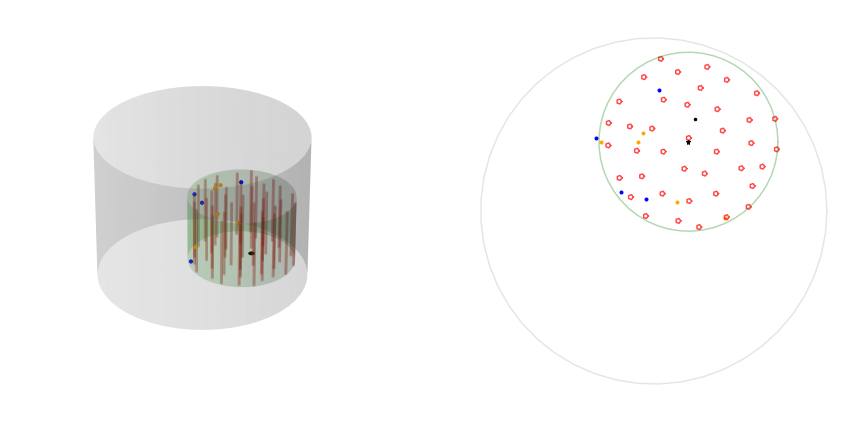

In [661]:
# Plot cylinder and objects 
# code from others - hence not provided

#_________Plot nest____________________________________________________________________________________________
   
nest_x = nest_loc['x']
nest_y = nest_loc['y']
nest_z = nest_loc['z']
nest_radius = 0.02
alph = 1

#_________________________________________________________________________________________________________________

# plot the nest in 3D
circle = Circle((nest_x,nest_y), nest_radius, alpha = alph, color = 'black')
ax_xyz.add_patch(circle)
art3d.pathpatch_2d_to_3d(circle, z=nest_z, zdir='z')

# plot the nest in 2D
ax_xy.plot(nest_loc['x'],nest_loc['y'], color='black',marker='.',markersize=5,label='nest')
ax_xy.plot(0,0, color='black',marker='*',markersize=5,label='nest')


# _______________plot the clutter circle and cylinder______________________________________________________

clutX_3d,clutY_3d,clutZ_3d = data_for_cylinder_along_z(center_x=0,
                                     center_y=0,
                                     radius = clut_radius,
                                     height_z = obj_height, dim=3)

clutX_2d,clutY_2d,_ = data_for_cylinder_along_z(center_x=0,
                                     center_y=0,
                                     radius = clut_radius,
                                     height_z = 0)

ax_xyz.plot_surface(clutX_3d,clutY_3d,clutZ_3d, alpha=0.2, color='green')
ax_xy.plot(clutX_2d,clutY_2d, alpha=0.3, color='green')


#----------------------------------------------------------------------------------------------------------------
# plotting the exit and entry points

ax_xyz.scatter(exit_mid_mean.x_mean,exit_mid_mean.y_mean,exit_mid_mean.z_mean, marker = '.',alpha=1 , 
               color='blue',linewidth=2)

ax_xy.scatter(exit_mid_mean.x_mean,exit_mid_mean.y_mean,marker = '.' ,alpha=1, color='blue',linewidth=1)

ax_xyz.scatter(entry_mid_mean.x_mean,entry_mid_mean.y_mean,entry_mid_mean.z_mean, marker = '.',alpha=1 , 
               color='orange',linewidth=2)

ax_xy.scatter(entry_mid_mean.x_mean,entry_mid_mean.y_mean,marker = '.' ,alpha=1, color='orange',linewidth=1)


#----------------------------------------------------------------------------------------------------------------
    
ax_xyz.axis('off')
ax_xy.axis('off')
ax_xy.axis('equal')
ax_xyz.axis('auto')

plt.show()


In [650]:
# _____________ WILL BE NEEDED ____________________________

# fig.savefig(os.path.join((recording_path),('/entry_exit_{}.svg'.format(recording))))
check_fig = os.path.exists('{0}/Onradius_{1}_{2}_entry_exit.png'.format(recording_path,recording,bee_id))
if not check_fig:
    fig.savefig(('{0}/Onradius_{1}_{2}_entry_exit.png'.format(recording_path,recording,bee_id)))